In [1]:
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline
import sklearn.ensemble
import sklearn.metrics
import sklearn.tree
import sklearn.base
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hashlib
import os

np.random.seed(42)

Here are the main steps of a machine learning project:
1. Look at the big picture.
2. Get the data.
3. Discover and visualize the data to gain insights.
4. Prepare the data for Machine Learning algorithms.
5. Select a model and train it.
6. Fine-tune your model.
7. Present your solution.
8. Launch, monitor, and maintain your system.



## 2.1 Working with Real Data
We use the California Housing Prices dataset from the StatLib repository (see `Figure 2-1`). This dataset was based on data from the 1990 California census. It is not exactly recent, but it has many qualities for learning, so we will pretend it is recent data. We also added a categorical attribute and removed a few features for teaching purposes.
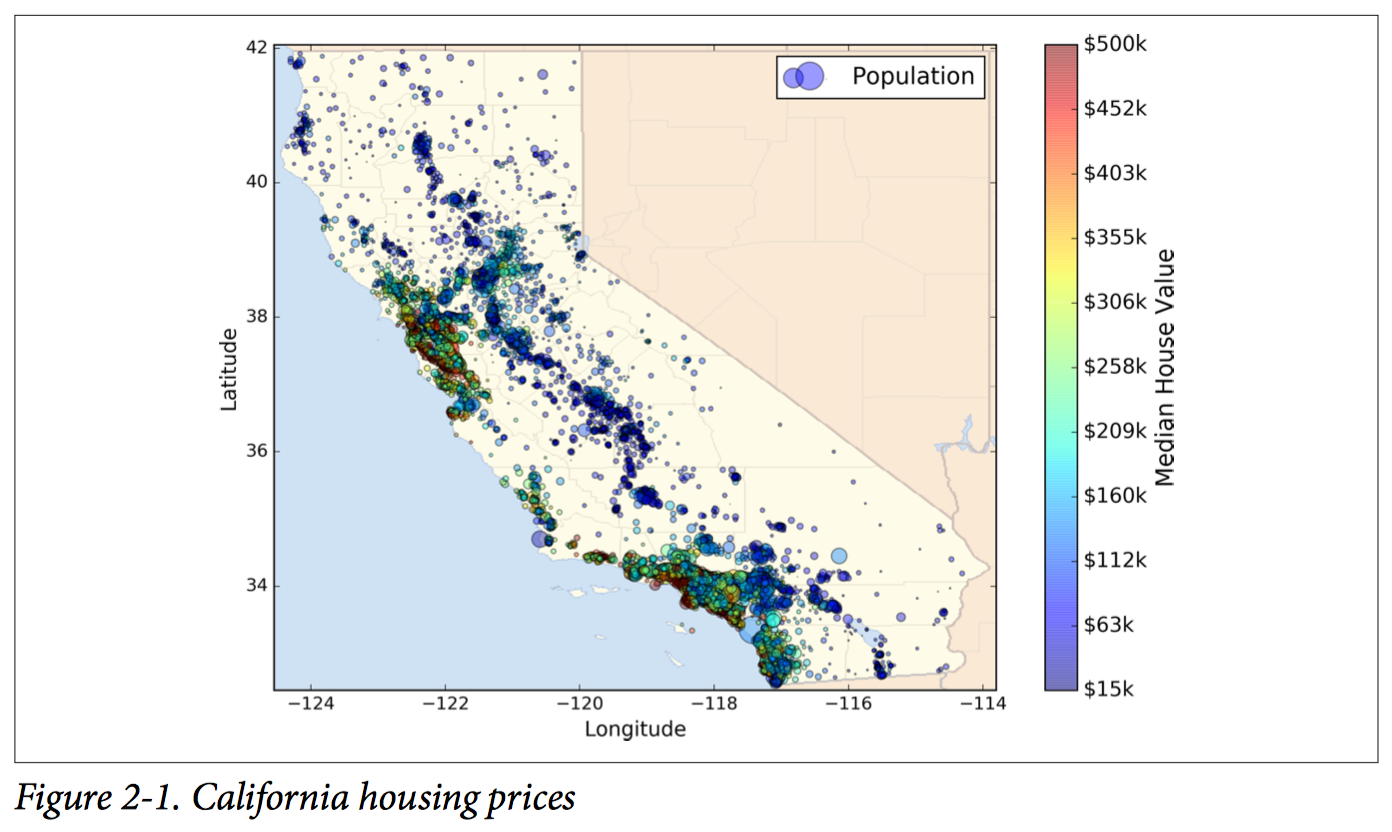



## 2.2 Look at the Big Picture
The first task you are asked to perform is to build a model of housing prices in California using the California census data. The data has metrics such as the population, median income, median housing price, and so on for each block group in California. Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). We will just call them “districts” for short.

### 2.2.1 Frame the Problem
The first question to ask your boss is what exactly is the business objective; building a model is probably not the end goal. How does the company expect to use and benefit from this model? This is important because it will determine how you frame the problem, what algorithms you will select, what performance measure you will use to evaluate your model, and how much effort you should spend tweaking it.

Your boss answers that your model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system (see `Figure 2-2`), along with many other signals. This downstream system will determine whether it is worth investing in a given area or not.
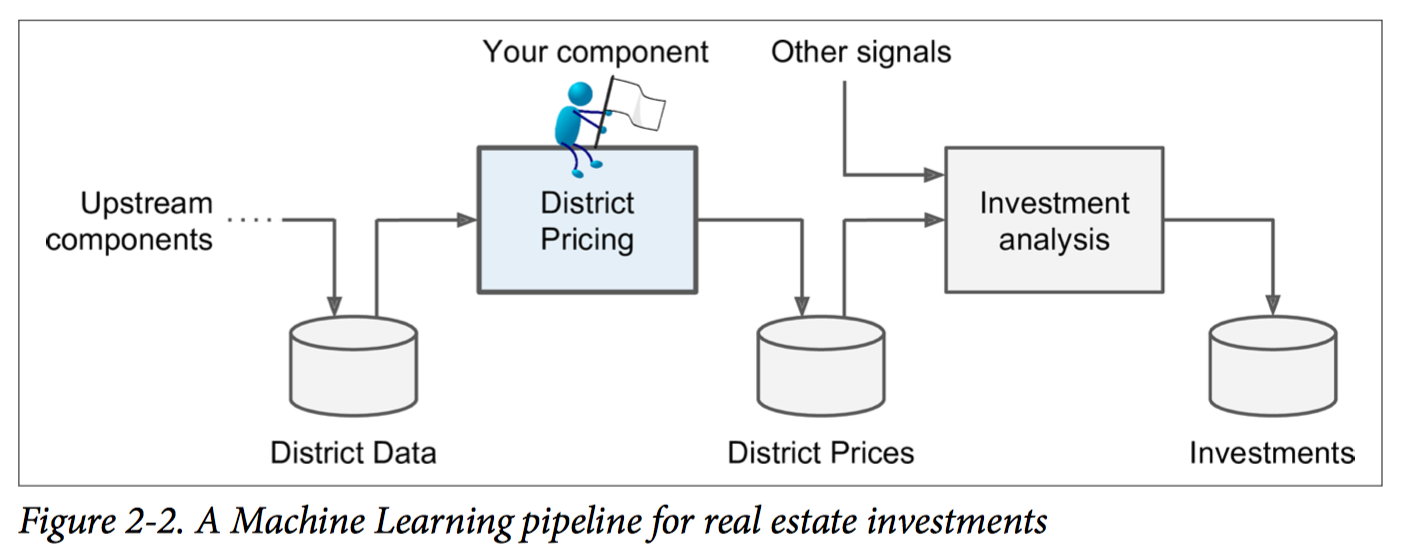

The next question to ask is what the current solution looks like (if any). It will often give you a reference performance, as well as insights on how to solve the problem. Your boss answers that the district housing prices are currently estimated manually by experts: a team gathers up-to-date information about a district (excluding median housing prices), and they use complex rules to come up with an estimate. This is costly and time-consuming, and their estimates are not great; their typical error rate is about 15%.

Okay, with all this information you are now ready to start designing your system. First, you need to frame the problem: is it supervised, unsupervised, or Reinforcement Learning? Is it a classification task, a regression task, or something else? Should you use batch learning or online learning techniques? Before you read on, pause and try to answer these questions for yourself.

Have you found the answers? Let’s see: it is clearly a typical supervised learning task since you are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price). Moreover, it is also a typical regression task, since you are asked to predict a value. More specifically, this is a multivariate regression problem since the system will use multiple features to make a prediction. Finally, there is no continuous flow of data coming in the system, there is no particular need to adjust to changing data rapidly, and the data is small enough to fit in memory, so plain batch learning should do just fine.

> **Pipelines**
> 
> A sequence of data processing components is called a data pipeline. Pipelines are very common in Machine Learning systems, since there is a lot of data to manipulate and many data transformations to apply.
> 
> Components typically run asynchronously. Each component pulls in a large amount of data, processes it, and spits out the result in another data store, and then some time later the next component in the pipeline pulls this data and spits out its own output, and so on. Each component is fairly self-contained: the interface between components is simply the data store. This makes the system quite simple to grasp (with the help of a data flow graph), and different teams can focus on different components. Moreover, if a component breaks down, the downstream components can often continue to run normally (at least for a while) by just using the last output from the broken component. This makes the architecture quite robust.
> 
> On the other hand, a broken component can go unnoticed for some time if proper monitoring is not implemented. The data gets stale and the overall system’s performance drops.

### 2.2.2 Select a Performance Measure
Your next step is to select a performance measure. A typical performance measure for regression problems is the `Root Mean Square Error` (RMSE). It measures the standard deviation of the errors the system makes in its predictions. The mathematical formula to compute the RMSE is:
- $RMSE(X, h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)})^2}$

> **Notations**
> This equation introduces several very common Machine Learning notations that we will use throughout this book:
> - $m$ is the number of instances in the dataset you are measuring the RMSE on
> - $x^{(i)}$ is a vector of all the feature values (excluding the label) of the $i^{th}$ instance in the dataset, and $y^{(i)}$ is its label (the desired output value for that instance).
> - $X$ is a matrix containing all the feature values (excluding labels) of all instances in the dataset. There is one row per instance and the $i^{th}$ row is equal to the transpose of $x^{(i)}$ , noted $(x^{(i)})^T$.
> - $h$ is your system’s prediction function, also called a `hypothesis`. When your system is given an instance’s feature vector $x^{(i)}$ , it outputs a predicted value $\hat{y}^{(i)} = h(x^{(i)})$ for that instance.
> - $RMSE(X,h)$ is the cost function measured on the set of examples using your hypothesis $h$.

Even though the RMSE is generally the preferred performance measure for regression tasks, in some contexts you may prefer to use another function. For example, suppose that there are many outlier districts. In that case, you may consider using the `Mean Absolute Error` (also called the `Average Absolute Deviation`):
- $MAE(X, h) = \frac{1}{m}\sum_{i=1}^{m}|h(x^{(i)}) - y^{(i)}|$

Both the `RMSE` and the `MAE` are ways to measure the distance between two vectors: the vector of predictions and the vector of target values. Various distance measures, or norms, are possible:
- Computing the RMSE corresponds to the `Euclidian norm`: it is the notion of distance you are familiar with. It is also called the $\ell_2$ norm, noted $\Vert \bullet \Vert_2$ (or just $\Vert \bullet \Vert$).
- Computing the MAE corresponds to the $\ell_1$ norm, noted $\Vert \bullet \Vert_1$. It is sometimes called the `Manhattan norm`.
- More generally, the $\ell_k$ norm of a vector $\mathrm{v}$ containing $\mathrm{n}$ elements is defined as $\Vert \mathrm{v} \Vert_k = (|v_0|^k + |v_1|^k + ... + |v_n|^k)^{\frac{1}{k}}$. $\ell_0$ just gives the cardinality of the vector (i.e., the number of elements), and $\ell_{\infty}$ gives the maximum absolute value in the vector.
- The higher the norm index, the more it focuses on large values and neglects small ones. This is why the RMSE is more sensitive to outliers than the MAE. But when outliers are exponentially rare (like in a `bell-shaped curve`), the RMSE performs very well and is generally preferred.

### 2.2.3 Check the Assumptions
Lastly, it is good practice to list and verify the assumptions that were made so far (by you or others); this can catch serious issues early on. For example, the district prices that your system outputs are going to be fed into a downstream Machine Learning system, and we assume that these prices are going to be used as such. But what if the downstream system actually converts the prices into categories (e.g., “cheap,” “medium,” or “expensive”) and then uses those categories instead of the prices themselves? In this case, getting the price perfectly right is not important at all; your system just needs to get the category right. If that’s so, then the problem should have been framed as a classification task, not a regression task. You don’t want to find this out after working on a regression system for months.

## 2.3 Get the Data

### 2.3.1 Create the Workspace
Install jupyter and numpy/pandas/matplotlib.

### 2.3.2 Download the Data
Download the California Housing Prices dataset.

```python
import os 
import tarfile 
from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
HOUSING_PATH = "datasets/housing" 
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path) 
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path) 
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path=housing_path) 
    housing_tgz.close()
```

### 2.3.3 Take a Quick Look at the Data Structure
Let’s take a look at the top five rows:

In [2]:
def load_housing_data(housing_path):
    csv_path = os.path.join(housing_path, "datasets/housing.csv") 
    return pd.read_csv(csv_path)

housing = load_housing_data("")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district. There are 10 attributes: longitude, latitude, housing_median_age, total_rooms, total_bed rooms, population, households, median_income, median_house_value, and ocean_proximity.

The `info()` method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values:

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Notice that the total_bed rooms attribute has only 20,433 non-null values, meaning that 207 districts are missing this feature. We will need to take care of this later.

All attributes are numerical, except the ocean_proximity field. Its type is object, so it could hold any kind of Python object, but since you loaded this data from a CSV file you know that it must be a text attribute. When you looked at the top five rows, you probably noticed that the values in that column were repetitive, which means that it is probably a categorical attribute. You can find out what categories exist and how many districts belong to each category by using the `value_counts()` method:

In [4]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

The `describe()` method shows a summary of the numerical attributes:

In [5]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Another quick way to get a feel of the type of data you are dealing with is to plot a histogram for each numerical attribute. A histogram shows the number of instances (on the vertical axis) that have a given value range (on the horizontal axis). You can either plot this one attribute at a time, or you can call the `hist()` method on the whole dataset, and it will plot a histogram for each numerical attribute. 

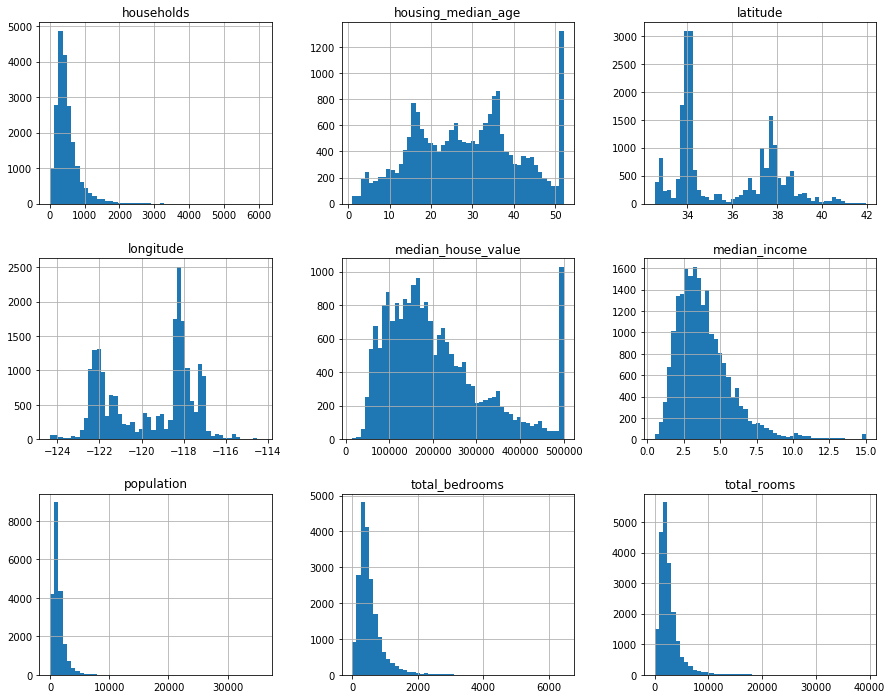

In [6]:
housing.hist(bins=50, figsize=(15,12)) 
plt.show()

Notice a few things in these histograms:
1. The `median income` attribute does not look like it is expressed in US dollars. After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually 15.0001) for higher median incomes, and at 0.5 (actually 0.4999) for lower median incomes. Working with preprocessed attributes is common in Machine Learning, and it is not necessarily a problem, but you should try to understand how the data was computed.

2. The `housing median age` and the `median house value` were also capped. The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit. You need to check with your client team (the team that will use your system’s output) to see if this is a problem or not. If they tell you that they need precise predictions even beyond `$500,000`, then you have mainly two options:
    - a. Collect proper labels for the districts whose labels were capped.
    - b. Remove those districts from the training set (and also from the test set, since your system should not be evaluated poorly if it predicts values beyond `$500,000`).

3. These attributes have very different scales. We will discuss this later in this chapter when we explore feature scaling.

4. Finally, many histograms are tail heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### 2.3.4 Create a Test Set
Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset, and set them aside:

In [7]:
# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


This works, but it is not perfect: if you run the program again, it will generate a different test set! Over time, you (or your Machine Learning algorithms) will get to see the whole dataset, which is what you want to avoid.

ne option is to set the random number generator’s seed before calling `np.random.permutation()`, so that it always generates the same shuffled indices.

But this solution will break next time you fetch an updated dataset. A common solution is to use each instance’s identifier to decide whether or not it should go in the test set (assuming instances have a unique and immutable identifier). For example, you could compute a hash of each instance’s identifier, keep only the last byte of the hash, and put the instance in the test set if this value is lower or equal to 51 (~20% of 256). This ensures that the test set will remain consistent across multiple runs, even if you refresh the dataset. The new test set will contain 20% of the new instances, but it will not contain any instance that was previously in the training set. Here is a possible implementation:

In [8]:
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

Unfortunately, the housing dataset does not have an identifier column. The simplest solution is to use the row index as the ID:

In [9]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
20,20,-122.27,37.85,40.0,751.0,184.0,409.0,166.0,1.3578,147500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


If you use the row index as a unique identifier, you need to make sure that new data gets appended to the end of the dataset, and no row ever gets deleted. If this is not possible, then you can try to use the most stable features to build a unique identifier. For example, a district’s latitude and longitude are guaranteed to be stable for a few million years, so you could combine them into an ID like so:

In [10]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


`Scikit-Learn` provides a few functions to split datasets into multiple subsets in various ways. The simplest function is `train_test_split`, which does pretty much the same thing as the function `split_train_test` defined earlier, with a couple of additional features:
1. A random_state parameter that allows you to set the random generator seed as explained previously
2. You can pass it multiple datasets with an identical number of rows, and it will split them on the same indices (this is very useful, for example, if you have a separate DataFrame for labels)

In [11]:
train_set, test_set = sklearn.model_selection.train_test_split(housing, test_size=0.2, random_state=42)
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


So far we have considered purely random sampling methods. This is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not, you run the risk of introducing a significant sampling bias. 

When a survey company decides to call 1,000 people to ask them a few questions, they try to ensure that these 1,000 people are representative of the whole population. For example, the US population is composed of 51.3% female and 48.7% male, so a well-conducted survey in the US would try to maintain this ratio in the sample. This is called `stratified sampling`: the population is divided into homogeneous subgroups called strata, and the right number of instances is sampled from each stratum to guarantee that the test set is representative of the overall population.

Suppose you chatted with experts who told you that the `median income` is a very important attribute to predict `median housing prices`. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. Let’s look at the median income histogram more closely (原书上的图有误导性):

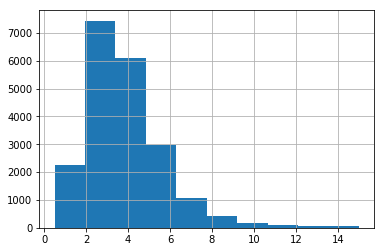

In [12]:
housing["median_income"].hist()
plt.show()

Most median income values are clustered around 2–5 (tens of thousands of dollars), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate of the stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code creates an income category attribute by dividing the median income by 1.5 (to limit the number of income categories), and rounding up using ceil (to have discrete categories), and then merging all the categories greater than 5 into category 5:

In [13]:
# Divide by 1.5 to limit the number of income categories
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
# Label those above 5 as 5
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

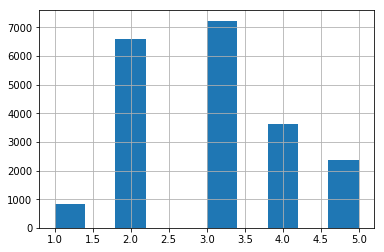

In [14]:
housing["income_cat"].hist()
plt.show()

Now you are ready to do stratified sampling based on the income category. For this you can use Scikit-Learn’s `StratifiedShuffleSplit` class:

In [15]:
split = sklearn.model_selection.StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 

for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

`Figure 2-10` compares the income category proportions in the overall dataset, in the test set generated with stratified sampling, and in a test set generated using purely random sampling. As you can see, the test set generated using stratified sampling has income category proportions almost identical to those in the full dataset, whereas the test set generated using purely random sampling is quite skewed.
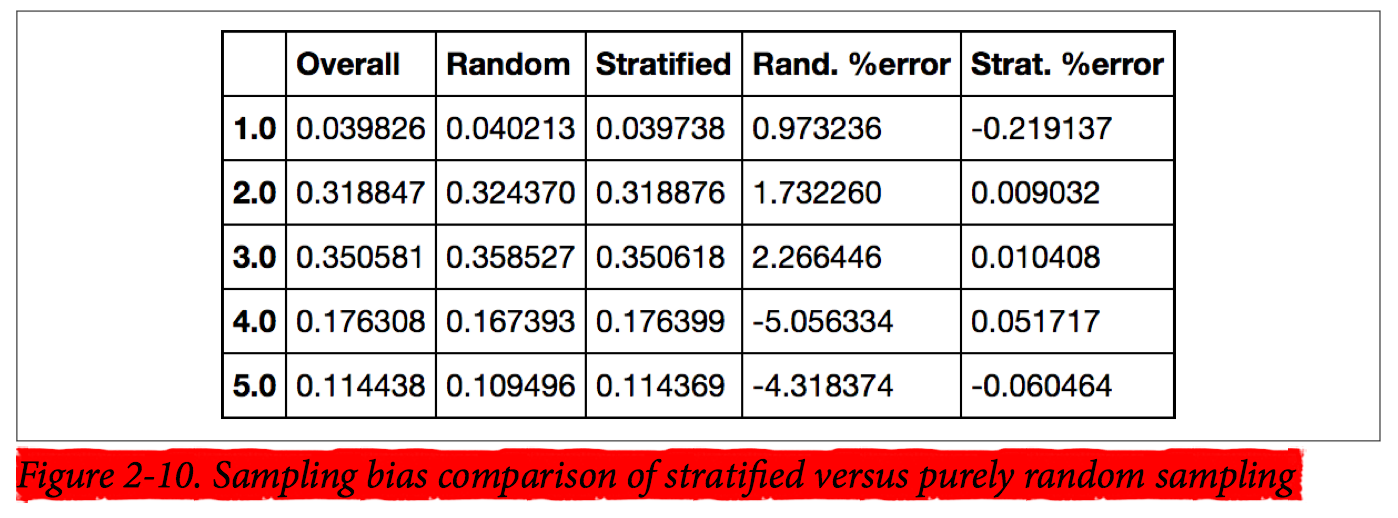

Now you should remove the `income_cat` attribute so the data is back to its original state:

In [16]:
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

***We spent quite a bit of time on test set generation for a good reason: this is an often neglected but critical part of a Machine Learning project. Moreover, many of these ideas will be useful later when we discuss cross-validation. Now it’s time to move on to the next stage: exploring the data.***



## 2.4 Discover and Visualize the Data to Gain Insights
So far you have only taken a quick glance at the data to get a general understanding of the kind of data you are manipulating. Now the goal is to go a little bit more in depth.

First, make sure you have put the test set aside and you are only exploring the training set. Also, if the training set is very large, you may want to sample an exploration set, to make manipulations easy and fast. In our case, the set is quite small so you can just work directly on the full set. Let’s create a copy so you can play with it without harming the training set:

In [17]:
housing = strat_train_set.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


### 2.4.1 Visualizing Geographical Data
Since there is geographical information, it is a good idea to create a scatterplot of all districts to visualize the data:

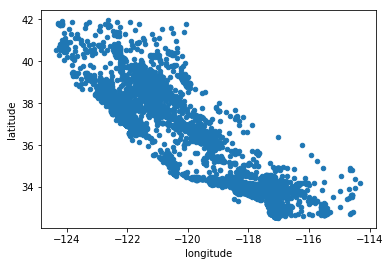

In [18]:
housing.plot(kind="scatter", x="longitude", y="latitude")
plt.show()

It is hard to see any particular pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places where there is a high density of data points:

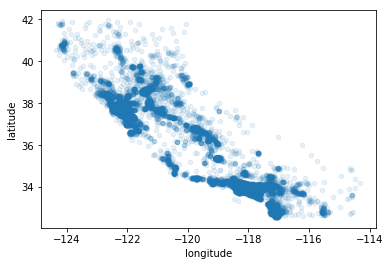

In [19]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
plt.show()

Now that’s much better: you can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

More generally, our brains are very good at spotting patterns on pictures, but you may need to play around with visualization parameters to make the patterns stand out.

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option $s$), and the color represents the price (option $c$). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices):

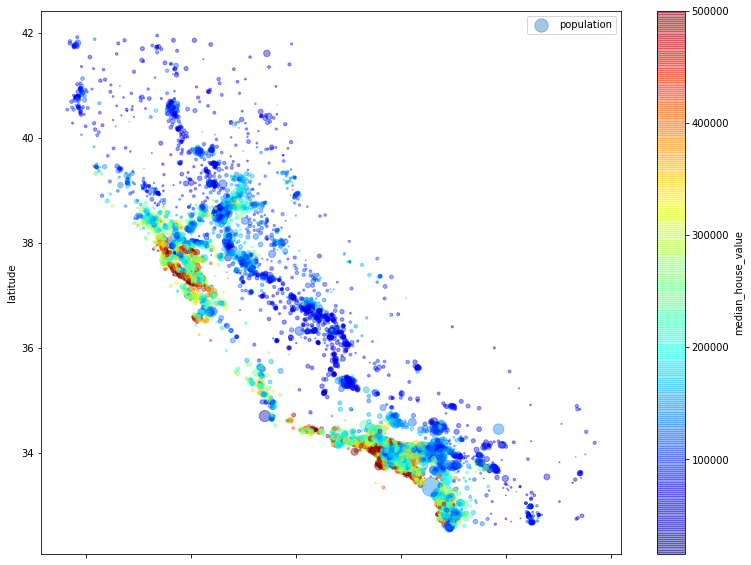

In [20]:
housing.plot(kind="scatter", x="longitude", y="latitude", colorbar=True,
             alpha=0.4, figsize=(13,10), label="population", 
             s=housing["population"]/100, 
             c="median_house_value", 
             cmap=plt.get_cmap("jet"), ) 
plt.legend()
plt.show()

This image tells you that the housing prices are very much related to the location (e.g., close to the ocean) and to the population density. It will probably be useful to use a clustering algorithm to detect the main clusters, and add new features that measure the proximity to the cluster centers. The ocean proximity attribute may be useful as well, although in Northern California the housing prices in coastal districts are not too high, so it is not a simple rule.

### 2.4.2 Looking for Correlations
Since the dataset is not too large, you can easily compute the standard correlation coefficient (also called Pearson’s r) between every pair of attributes using the `corr()` method:

In [21]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median house value tends to go up when the median income goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., prices have a slight tendency to go down when you go north). Finally, coefficients close to zero mean that there is no linear correlation. `Figure 2-14` shows various plots along with the correlation coefficient between their horizontal and vertical axes:
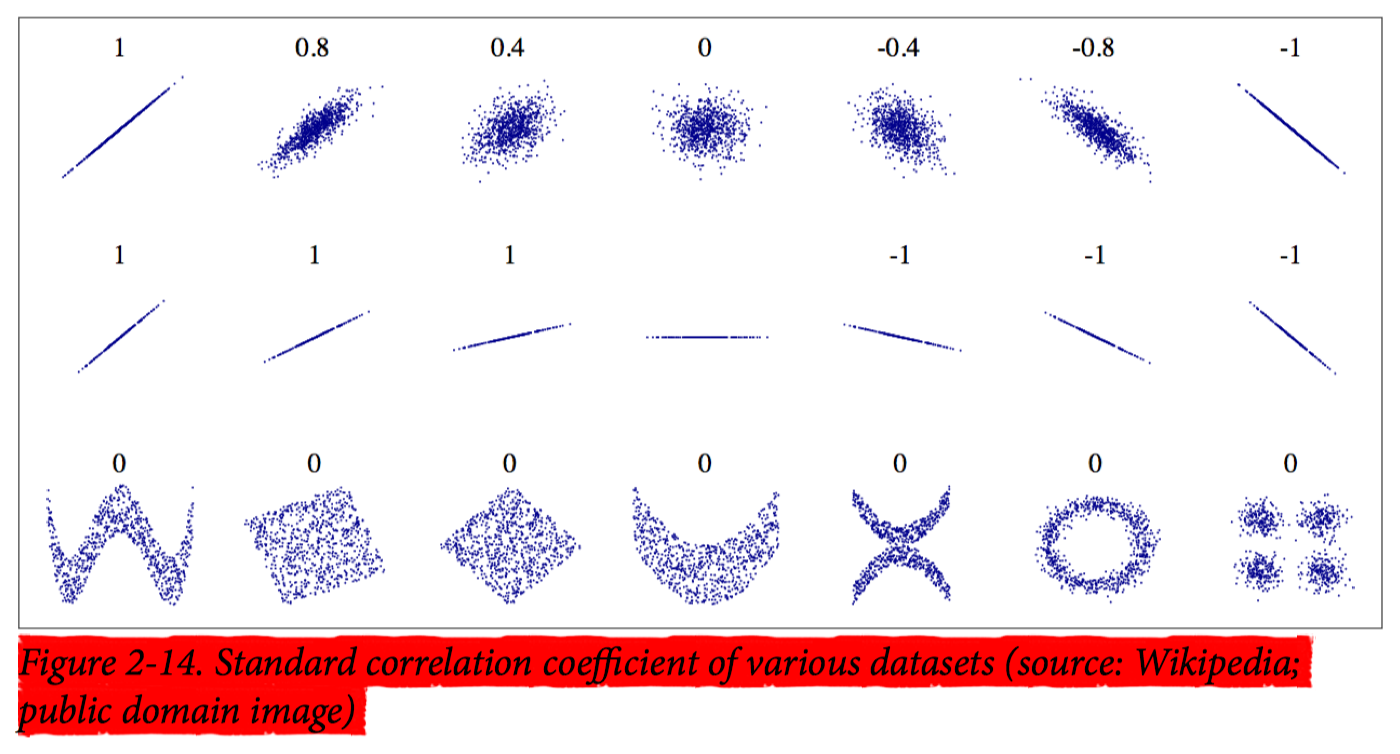

> The correlation coefficient only measures linear correlations (“if x goes up, then y generally goes up/down”). It may completely miss out on nonlinear relationships (e.g., “if x is close to zero then y generally goes up”). Note how all the plots of the bottom row have a correlation coefficient equal to zero despite the fact that their axes are clearly not independent: these are examples of nonlinear relationships. Also, the second row shows examples where the correlation coefficient is equal to 1 or –1; notice that this has nothing to do with the slope. For example, your height in inches has a correlation coefficient of 1 with your height in feet or in nanometers.

Another way to check for correlation between attributes is to use Pandas’ `scatter_matrix` function, which plots every numerical attribute against every other numerical attribute. Since there are now $11$ numerical attributes, you would get $11^2 = 121$ plots, which would not fit on a page, so let’s just focus on a few promising attributes that seem most correlated with the median housing value:

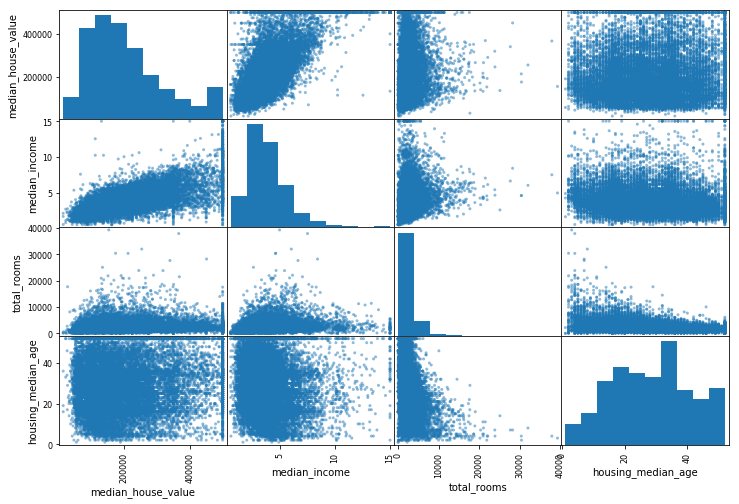

In [22]:
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"] 
pd.plotting.scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

The main diagonal (top left to bottom right) would be full of straight lines if Pandas plotted each variable against itself, which would not be very useful. So instead Pandas displays a histogram of each attribute (other options are available; see Pandas’ documentation for more details).

The most promising attribute to predict the `median house value` is the `median income`, so let’s zoom in on their correlation scatterplot:

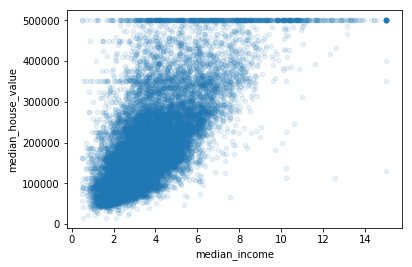

In [23]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)
plt.show()

This plot reveals a few things:
1. the correlation is indeed very strong; you can clearly see the upward trend and the points are not too dispersed. 
2. the price cap that we noticed earlier is clearly visible as a horizontal line at `$500,000`. But this plot reveals other less obvious straight lines: a horizontal line around `$450,000`, another around `$350,000`, perhaps one around `$280,000`, and a few more below that.

You may want to try removing the corresponding districts to prevent your algorithms from learning to reproduce these data quirks.

### 2.4.3 Experimenting with Attribute Combinations
Hopefully the previous sections gave you an idea of a few ways you can explore the data and gain insights. You identified a few data quirks that you may want to clean up before feeding the data to a Machine Learning algorithm, and you found interesting correlations between attributes, in particular with the target attribute. You also noticed that some attributes have a tail-heavy distribution, so you may want to transform them (e.g., by computing their logarithm). Of course, your mileage will vary considerably with each project, but the general ideas are similar.

One last thing you may want to do before actually preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [24]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"] 
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"] 
housing["population_per_household"]=housing["population"]/housing["households"]

And now let’s look at the correlation matrix again:

In [25]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

The new `bedrooms_per_room` attribute is much more correlated with the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

This round of exploration does not have to be absolutely thorough; the point is to start off on the right foot and quickly gain insights that will help you get a first reasonably good prototype. But this is an iterative process: once you get a prototype up and running, you can analyze its output to gain more insights and come back to this exploration step.

## 2.5 Prepare the Data for Machine Learning Algorithms
It’s time to prepare the data for your Machine Learning algorithms. Instead of just doing this manually, you should write functions to do that, for several good reasons:
- This will allow you to reproduce these transformations easily on any dataset (e.g., the next time you get a fresh dataset).
- You will gradually build a library of transformation functions that you can reuse in future projects.
- You can use these functions in your live system to transform the new data before feeding it to your algorithms.
- This will make it possible for you to easily try various transformations and see which combination of transformations works best.

But first let’s revert to a clean training set (by copying strat_train_set once again), and let’s separate the predictors and the labels since we don’t necessarily want to apply the same transformations to the predictors and the target values (note that `drop()` creates a copy of the data and does not affect strat_train_set):

In [26]:
housing = strat_train_set.drop("median_house_value", axis=1) 
housing_labels = strat_train_set["median_house_value"].copy()

### 2.5.1 Data Cleaning
Most Machine Learning algorithms cannot work with missing features, so let’s create a few functions to take care of them. You noticed earlier that the total_bedrooms attribute has some missing values, so let’s fix this. You have three options:
- Get rid of the corresponding districts.
- Get rid of the whole attribute.
- Set the values to some value (zero, the mean, the median, etc.).

You can accomplish these easily using DataFrame’s `dropna()`, `drop()`, and `fillna()` methods:
```python
housing.dropna(subset=["total_bedrooms"])   # option 1
housing.drop("total_bedrooms", axis=1)      # option 2
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median)    # option 3
```

If you choose option 3, you should compute the median value on the training set, and use it to fill the missing values in the training set, but also don’t forget to save the median value that you have computed. You will need it later to replace missing values in the test set when you want to evaluate your system, and also once the system goes live to replace missing values in new data.

Scikit-Learn provides a handy class to take care of missing values: Imputer. Here is how to use it. First, you need to create an Imputer instance, specifying that you want to replace each attribute’s missing values with the median of that attribute:

In [27]:
imputer = sklearn.preprocessing.Imputer(strategy="median")

# the median can only be computed on numerical attributes, we need to create a copy 
# of the data without the text attribute ocean_proximity
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

# median of each attribute
# imputer.statistics_
print("median of each attribute: ", housing_num.median().values)

X = imputer.transform(housing_num)

# X is a plain Numpy array containing the transformed features
# you can put it back into a Pandas DataFrame
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.head()

median of each attribute:  [ -118.51      34.26      29.      2119.5      433.      1164.       408.
     3.5409]


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### 2.5.2 Handling Text and Categorical Attributes
`ocean_proximity` is a text attribute so we cannot compute its median. Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these text labels to numbers.

Scikit-Learn provides a transformer for this task called LabelEncoder:

In [28]:
encoder = sklearn.preprocessing.LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
housing_cat_encoded.shape

(16512,)

We can use this numerical data in any ML algorithm now. You can look at the mapping that this encoder has learned using the `classes_` attribute (“<1H OCEAN” is mapped to 0, “INLAND” is mapped to 1, etc.):

In [29]:
encoder.classes_

array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'], dtype=object)

One issue with this representation is that ML algorithms will assume that two nearby values are more similar than two distant values. Obviously this is not the case (for example, categories 0 and 4 are more similar than categories 0 and 1). To fix this issue, a common solution is to create one binary attribute per category: one attribute equal to 1 when the category is “<1H OCEAN” (and 0 otherwise), another attribute equal to 1 when the category is “INLAND” (and 0 otherwise), and so on. This is called `one-hot encoding`, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold).

Scikit-Learn provides a `OneHotEncoder` encoder to convert integer categorical values into one-hot vectors. Let’s encode the categories as one-hot vectors. Note that `fit_transform()` expects a 2D array, but housing_cat_encoded is a 1D array, so we need to reshape it:

In [30]:
encoder = sklearn.preprocessing.OneHotEncoder()

# reshape() function allows one dimension to be –1, which means 
# “unspecified”: the value is inferred from the length of the array 
# and the remaining dimensions
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After onehot encoding we get a matrix with thousands of columns, and the matrix is full of zeros except for one 1 per row. Using up tons of memory mostly to store zeros would be very wasteful, so instead a sparse matrix only stores the location of the nonzero elements. You can use it mostly like a normal 2D array, but if you really want to convert it to a (dense) NumPy array, just call the `toarray()` method:

In [31]:
housing_cat_1hot.toarray()

array([[ 1.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.],
       ..., 
       [ 0.,  1.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.]])

We can apply both transformations (from text categories to integer categories, then from integer categories to one-hot vectors) in one shot using the `LabelBinarizer` class:

In [32]:
encoder = sklearn.preprocessing.LabelBinarizer()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       ..., 
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0]])

Note that this returns a dense NumPy array by default. You can get a sparse matrix instead by passing `sparse_output=True` to the `LabelBinarizer` constructor.

### 2.5.3 Custom Transformers
Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: `fit()`, `transform()`, and `fit_transform()`. You can get the last one for free by simply adding `TransformerMixin` as a base class. Also, if you add `BaseEstimator` as a base class, you will get two extra methods (`get_params()` and `set_params()`) that will be useful for automatic hyperparameter tuning. 

For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [33]:
# column index
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In this example the transformer has one hyperparameter, `add_bedrooms_per_room`, set to True by default. This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time).

### 2.5.4 Feature Scaling
Most of Machine Learning algorithms can't perform well when the input numerical attributes have very different scales. 

This is the case for the housing data: the total number of rooms ranges from about 6 to 39,320, while the median incomes only range from 0 to 15. Note that scaling the target values is generally not required.

There are two common ways to get all attributes to have the same scale:
- Min-max scaling (`normalization`): is quite simple: values are shifted and rescaled so that they end up ranging from 0 to 1. We do this by subtracting the min value and dividing by the max minus the min. Scikit-Learn provides a transformer called `MinMaxScaler` for this. It has a `feature_range` hyperparameter that lets you change the range if you don’t want 0–1 for some reason.

- Standardization is quite different: first it subtracts the mean value (so standardized values always have a zero mean), and then it divides by the variance so that the resulting distribution has unit variance. Unlike min-max scaling, standardization does not bound values to a specific range, which may be a problem for some algorithms. 

Standardization is much less affected by outliers. For example, suppose a district had a median income equal to 100 (by mistake). Min-max scaling would then crush all the other values from 0–15 down to 0–0.15, whereas standardization would not be much affected. Scikit-Learn provides a transformer called `StandardScaler` for standardization.

> **As with all the transformations, it is important to fit the scalers to the training data only, not to the full dataset (including the test set). Only then can you use them to transform the training set and the test set (and new data).**

### 2.5.5 Transformation Pipelines
As you can see, there are many data transformation steps that need to be executed in the right order. Fortunately, Scikit-Learn provides the Pipeline class to help with such sequences of transformations:

In [34]:
num_pipeline = sklearn.pipeline.Pipeline([
    ('imputer', sklearn.preprocessing.Imputer(strategy="median")), 
    ('attribs_adder', CombinedAttributesAdder()), 
    ('std_scaler', sklearn.preprocessing.StandardScaler()), ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[-1.15604281,  0.77194962,  0.74333089, ..., -0.31205452,
        -0.08649871,  0.15531753],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.21768338,
        -0.03353391, -0.83628902],
       [ 1.18684903, -1.34218285,  0.18664186, ..., -0.46531516,
        -0.09240499,  0.4222004 ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.3469342 ,
        -0.03055414, -0.52177644],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.02499488,
         0.06150916, -0.30340741],
       [-1.43579109,  0.99645926,  1.85670895, ..., -0.22852947,
        -0.09586294,  0.10180567]])

The `Pipeline` constructor takes a list of name/estimator pairs defining a sequence of steps. All but the last estimator must be transformers (i.e., they must have a `fit_transform()` method). The names can be anything you like.

When you call the pipeline’s `fit()` method, it calls `fit_transform()` sequentially on all transformers, passing the output of each call as the parameter to the next call, until it reaches the final estimator, for which it just calls the `fit()` method.

The pipeline exposes the same methods as the final estimator. In this example, the last estimator is a `StandardScaler`, which is a transformer, so the pipeline has a `transform()` method that applies all the transforms to the data in sequence (it also has a `fit_transform` method that we could have used instead of calling `fit()` and then `transform()`).

You now have a pipeline for numerical values, and you also need to apply the `LabelBinarizer` on the categorical values: how can you join these transformations into a single pipeline? Scikit-Learn provides a `FeatureUnion` class for this. You give it a list of transformers (which can be entire transformer pipelines), and when its `transform()` method is called it runs each transformer’s `transform()` method in parallel, waits for their output, and then concatenates them and returns the result. A full pipeline handling both numerical and categorical attributes may look like this:

In [35]:
# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet
class DataFrameSelector(sklearn.base.BaseEstimator, sklearn.base.TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    
class MyLabelBinarizer(sklearn.base.TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = sklearn.preprocessing.LabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

num_pipeline = sklearn.pipeline.Pipeline([
        ('selector', DataFrameSelector(num_attribs)),
        ('imputer', sklearn.preprocessing.Imputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', sklearn.preprocessing.StandardScaler()),
    ])

cat_pipeline = sklearn.pipeline.Pipeline([
        ('selector', DataFrameSelector(cat_attribs)),
        ('label_binarizer', MyLabelBinarizer()),
    ])

full_pipeline = sklearn.pipeline.FeatureUnion(transformer_list=[
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])

housing_prepared = full_pipeline.fit_transform(housing)
housing_prepared

array([[-1.15604281,  0.77194962,  0.74333089, ...,  0.        ,
         0.        ,  0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 1.58648943, -0.72478134, -1.56295222, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.78221312, -0.85106801,  0.18664186, ...,  0.        ,
         0.        ,  0.        ],
       [-1.43579109,  0.99645926,  1.85670895, ...,  0.        ,
         1.        ,  0.        ]])

## 2.6 Select and Train a Model

### 2.6.1 Training and Evaluating on the Training Set
Let’s first train a Linear Regression model:

In [36]:
lin_reg = sklearn.linear_model.LinearRegression() 
lin_reg.fit(housing_prepared, housing_labels)

# try it out on a few instances from the training set
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:\t", lin_reg.predict(some_data_prepared))
print("Labels:\t\t", list(some_labels))

Predictions:	 [ 210644.60459286  317768.80697211  210956.43331178   59218.98886849
  189747.55849879]
Labels:		 [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


It works, although the predictions are not exactly accurate. Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error` function:

In [37]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = sklearn.metrics.mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.198198489234

Okay, this is better than nothing but clearly not a great score: most districts’ `median_housing_values` range between `$120,000` and `$265,000`, so a typical prediction error of `$68,628` is not very satisfying. 

This is an example of a model underfitting the training data. The main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. Let’s try a more complex model to see how it does.

Let’s train a DecisionTreeRegressor:

In [38]:
tree_reg = sklearn.tree.DecisionTreeRegressor() 
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = sklearn.metrics.mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. As we saw earlier, you don’t want to touch the test set until you are ready to launch a model you are confident about, so you need to use part of the training set for training, and part for model validation.

### 2.6.2 Better Evaluation Using Cross-Validation
One way to evaluate the Decision Tree model would be to use the `train_test_split` function to split the training set into a smaller training set and a validation set, then train your models against the smaller training set and evaluate them against the validation set. It’s a bit of work, but nothing too difficult and it would work fairly well.

A great alternative is to use Scikit-Learn’s `cross-validation` feature. The following code performs `K-fold cross-validation`: it randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores:

In [39]:
scores = sklearn.model_selection.cross_val_score(tree_reg, housing_prepared, 
                                                 housing_labels, scoring="neg_mean_squared_error", 
                                                 cv=10) 
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [ 69316.02634772  65498.84994772  71404.25935862  69098.46240168
  70580.30735263  75540.88413124  69717.93143674  70428.42648461
  75888.17618283  68976.12268448]
Mean: 70644.9446328
Standard deviation: 2938.93789263


> Scikit-Learn cross-validation features expect a utility function (greater is better) rather than a cost function (lower is better), so the scoring function is actually the opposite of the MSE (i.e., a negative value), which is why the preceding code computes -scores before calculating the square root.

Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately `71,200`, generally `±3,200`. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible.

Let’s compute the same scores for the Linear Regression model just to be sure:

In [40]:
lin_scores = sklearn.model_selection.cross_val_score(lin_reg, housing_prepared, housing_labels, 
                                                     scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [ 66782.73843989  66960.118071    70347.95244419  74739.57052552
  68031.13388938  71193.84183426  64969.63056405  68281.61137997
  71552.91566558  67665.10082067]
Mean: 69052.4613635
Standard deviation: 2731.6740018


The Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

Let’s try the `RandomForestRegressor`. `Random Forests` work by training many Decision Trees on random subsets of the features, then averaging out their predictions. Building a model on top of many other models is called `Ensemble Learning`, and it is often a great way to push ML algorithms even further:

In [41]:
forest_reg = sklearn.ensemble.RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = sklearn.metrics.mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

22252.738943108321

In [42]:
forest_scores = sklearn.model_selection.cross_val_score(forest_reg, housing_prepared, housing_labels,
                                                        scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [ 52869.23106834  49189.93801195  51726.73647871  54995.98190463
  50979.93079904  55978.43765914  52283.7609046   51001.92227546
  54447.35786983  53389.94422283]
Mean: 52686.3241195
Standard deviation: 1971.26547795


This is much better: Random Forests look very promising. However, note that the score on the training set is still much lower than on the validation sets, meaning that the model is still overfitting the training set. Possible solutions for overfitting are to simplify the model, constrain it (i.e., regularize it), or get a lot more training data. However, before you dive much deeper in Random Forests, you should try out many other models from various categories of Machine Learning algorithms, without spending too much time tweaking the hyperparameters. The goal is to shortlist a few (two to five) promising models.

> You should save every model you experiment with, so you can come back easily to any model you want. Make sure you save both the hyperparameters and the trained parameters, as well as the cross-validation scores and perhaps the actual predictions as well. This will allow you to easily compare scores across model types, and compare the types of errors they make. You can easily save Scikit-Learn models by using Python’s pickle module, or using sklearn.externals.joblib, which is more efficient at serializing large NumPy arrays:

```python
from sklearn.externals import joblib
joblib.dump(my_model, "my_model.pkl") 
# and later...
my_model_loaded = joblib.load("my_model.pkl")
```

## 2.7 Fine-Tune Your Model
Let’s assume that you now have a shortlist of promising models. You now need to fine-tune them. Let’s look at a few ways you can do that.

### 2.7.1 Grid Search
One way to do that would be to fiddle with the hyperparameters manually, until you find a great combination of hyperparameter values. This would be very tedious work, and you may not have time to explore many combinations.

Instead you should get Scikit-Learn’s `GridSearchCV` to search for you. All you need to do is tell it which hyperparameters you want it to experiment with, and what values to try out, and it will evaluate all the possible combinations of hyperparameter values, using `cross-validation`:

In [43]:
# first evaluate 3 × 4 = 12 combinations of n_estimators and max_features hyperparameter values
# then try 2 × 3 = 6 combinations of hyperparameter values with the bootstrap hyperparameter
param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, 
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}, 
]

forest_reg = sklearn.ensemble.RandomForestRegressor()

# grid search will explore 12+6=18 combinations of hyperparameter values, 
# and it will train each model five times, there will be 18 × 5 = 90 rounds of training
grid_search = sklearn.model_selection.GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

> **Notes**
> 1. Since 30 is the maximum value of n_estimators that was evaluated, you should probably evaluate higher values as well, since the score may continue to improve.
> 2. If GridSearchCV is initialized with refit=True (which is the default), then once it finds the best estimator using crossvalidation, it retrains it on the whole training set. This is usually a good idea since feeding it more data will likely improve its performance.
> 3. You can treat some of the data preparation steps as hyperparameters. For example, the grid search will automatically find out whether or not to add a feature you were not sure about (e.g., using the add_bedrooms_per_room hyperparameter of your CombinedAttributesAdder transformer). It may similarly be used to automatically find the best way to handle outliers, missing features, feature selection, and more.

You can also get the best estimator directly:

In [44]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=6, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

And of course the evaluation scores are also available:

In [45]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64583.2383134 {'max_features': 2, 'n_estimators': 3}
55576.8737221 {'max_features': 2, 'n_estimators': 10}
52956.3066294 {'max_features': 2, 'n_estimators': 30}
60717.6157768 {'max_features': 4, 'n_estimators': 3}
52634.1052674 {'max_features': 4, 'n_estimators': 10}
50528.7451101 {'max_features': 4, 'n_estimators': 30}
58493.2146791 {'max_features': 6, 'n_estimators': 3}
52208.3486668 {'max_features': 6, 'n_estimators': 10}
49924.8890318 {'max_features': 6, 'n_estimators': 30}
58650.6191468 {'max_features': 8, 'n_estimators': 3}
52369.1878452 {'max_features': 8, 'n_estimators': 10}
50109.8456878 {'max_features': 8, 'n_estimators': 30}
62470.3421024 {'max_features': 2, 'bootstrap': False, 'n_estimators': 3}
54496.7862909 {'max_features': 2, 'bootstrap': False, 'n_estimators': 10}
60353.8008531 {'max_features': 3, 'bootstrap': False, 'n_estimators': 3}
52397.6755216 {'max_features': 3, 'bootstrap': False, 'n_estimators': 10}
59152.2214146 {'max_features': 4, 'bootstrap': False, 'n_estim

### 2.7.2 Randomized Search
The grid search approach is fine when you are exploring relatively few combinations, like in the previous example, but when the hyperparameter search space is large, it is often preferable to use RandomizedSearchCV instead. This class can be used in much the same way as the GridSearchCV class, but instead of trying out all possible combinations, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration. This approach has two main benefits:
- If you let the randomized search run for, say, 1,000 iterations, this approach will explore 1,000 different values for each hyperparameter (instead of just a few values per hyperparameter with the grid search approach).
- You have more control over the computing budget you want to allocate to hyperparameter search, simply by setting the number of iterations.

### 2.7.3 Ensemble Methods
Another way to fine-tune your system is to try to combine the models that perform best. The group (or “ensemble”) will often perform better than the best individual model (just like Random Forests perform better than the individual Decision Trees they rely on), especially if the individual models make very different types of errors. We will cover this topic in more detail in `Chapter 7`.

### 2.7.4 Analyze the Best Models and Their Errors
You will often gain good insights on the problem by inspecting the best models. For example, the RandomForestRegressor can indicate the relative importance of each attribute for making accurate predictions:

In [46]:
feature_importances = grid_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.32754893001195934, 'median_income'),
 (0.13835019350471953, 'INLAND'),
 (0.10531956070724346, 'pop_per_hhold'),
 (0.09139658055040592, 'bedrooms_per_room'),
 (0.076968776639663436, 'longitude'),
 (0.07043198869339834, 'latitude'),
 (0.05577360056115168, 'rooms_per_hhold'),
 (0.043866061924543169, 'housing_median_age'),
 (0.018063044805051474, 'total_rooms'),
 (0.01794828495917463, 'population'),
 (0.016650874220719983, 'total_bedrooms'),
 (0.015994298942109429, 'households'),
 (0.01166380333543238, '<1H OCEAN'),
 (0.0060806237459764181, 'NEAR OCEAN'),
 (0.0038394009525752966, 'NEAR BAY'),
 (0.00010397644587548846, 'ISLAND')]

With this information, you may want to try dropping some of the less useful features (e.g., apparently only one ocean_proximity category is really useful, so you could try dropping the others).

You should also look at the specific errors that your system makes, then try to understand why it makes them and what could fix the problem (adding extra features or, on the contrary, getting rid of uninformative ones, cleaning up outliers, etc.).

### 2.7.5 Evaluate Your System on the Test Set
After tweaking your models for a while, you eventually have a system that performs sufficiently well. Now is the time to evaluate the final model on the test set. There is nothing special about this process; just get the predictors and the labels from your test set, run your full_pipeline to transform the data (call transform(), not fit_transform()!), and evaluate the final model on the test set:

In [47]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1) 
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared) 
final_mse = sklearn.metrics.mean_squared_error(y_test, final_predictions) 
final_rmse = np.sqrt(final_mse)
final_rmse

47547.546074098922

The performance will usually be slightly worse than what you measured using crossvalidation if you did a lot of hyperparameter tuning (because your system ends up fine-tuned to perform well on the validation data, and will likely not perform as well on unknown datasets). It is not the case in this example, but when this happens you must resist the temptation to tweak the hyperparameters to make the numbers look good on the test set; the improvements would be unlikely to generalize to new data.

Now comes the project prelaunch phase: you need to present your solution (highlighting what you have learned, what worked and what did not, what assumptions were made, and what your system’s limitations are), document everything, and create nice presentations with clear visualizations and easy-to-remember statements (e.g., “the median income is the number one predictor of housing prices”).

## 2.8 Launch, Monitor, and Maintain Your System
Perfect, you got approval to launch! You need to get your solution ready for production, in particular by plugging the production input data sources into your system and writing tests.

You also need to write monitoring code to check your system’s live performance at regular intervals and trigger alerts when it drops. This is important to catch not only sudden breakage, but also performance degradation. This is quite common because models tend to “rot” as data evolves over time, unless the models are regularly trained on fresh data.

Evaluating your system’s performance will require sampling the system’s predictions and evaluating them. This will generally require a human analysis. These analysts may be field experts, or workers on a crowdsourcing platform (such as Amazon Mechanical Turk or CrowdFlower). Either way, you need to plug the human evaluation pipeline into your system.

You should also make sure you evaluate the system’s input data quality. Sometimes performance will degrade slightly because of a poor quality signal (e.g., a malfunctioning sensor sending random values, or another team’s output becoming stale), but it may take a while before your system’s performance degrades enough to trigger an alert. If you monitor your system’s inputs, you may catch this earlier. Monitoring the inputs is particularly important for online learning systems.

Finally, you will generally want to train your models on a regular basis using fresh data. You should automate this process as much as possible. If you don’t, you are very likely to refresh your model only every six months (at best), and your system’s performance may fluctuate severely over time. If your system is an online learning system, you should make sure you save snapshots of its state at regular intervals so you can easily roll back to a previously working state.